In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer, precision_recall_curve
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from _functions import custom_classification_report, plot_confusion_matrix, get_best_threshold_i

In [2]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
df.head()
df.isnull().sum()

title                              0
location                         354
description                        0
requirements                    2772
telecommuting                      0
has_company_logo                   0
has_questions                      0
fraudulent                         0
location_has_non_latin             0
description_has_non_latin          0
requirements_has_non_latin         0
has_requirements                   0
description_and_requirements       0
country_state                    301
country                          301
has_location                       0
has_location_details               0
dtype: int64

In [3]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']

# location, description, requirements, country will be dropped.
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+X_cat_cols+y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col]
y = y.values.ravel()

In [ ]:
###########################
##### Train the model #####
###########################


# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(random_state=42, max_iter=1000))
])

# compute class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(weights))

# set parameters for estimator
model.set_params(clf__class_weight=class_weights)
model.set_params(clf__class_weight=class_weights)

k = 5
kF = KFold(n_splits=k, shuffle=True, random_state=42)

# Make predictions and print classification report
y_pred_proba = cross_val_predict(model, X, y, cv=kF, method='predict_proba')
# y_log_pred_prob = cross_val_predict(model, X, y, cv=kF, method='predict_proba')[:, 1]

The best threshold is 0.641

Classification Report:
           precision    recall  f1-score  f2-score   support

Not Fraud      0.994     0.982     0.988     0.984     16739
    Fraud      0.794     0.920     0.852     0.892      1294

 accuracy                                    0.977     18033



<Figure size 600x500 with 0 Axes>

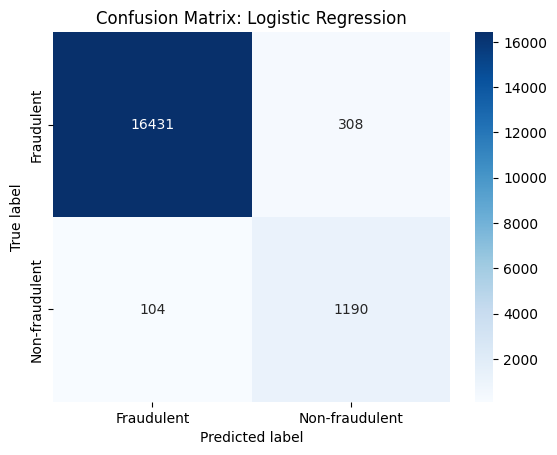

In [5]:
###########################
##### Display results #####
###########################
precision, recall, thresholds = precision_recall_curve(y, y_pred_proba.T[1].T)
best_threshold_i = get_best_threshold_i(precision, recall, beta=2)
print(f'The best threshold is {thresholds[best_threshold_i]:0.3f}\n')

y_pred = y_pred_proba.T[1].T >= thresholds[best_threshold_i]

print("Classification Report:")
print(custom_classification_report(y, y_pred, digits=3))
# clf = model.named_steps["clf"]
# print(clf.coef_)
fig, ax = plot_confusion_matrix(confusion_matrix(y, y_pred, labels=[0, 1]), f"Confusion Matrix: Logistic Regression")

In [ ]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = 'models/logistic_regression_model_k={k}.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)